Loading YOLO pose model...
Video: 67 frames at 30.00 FPS

Visualization saved as 'fencer_keypoints_visualization.png'


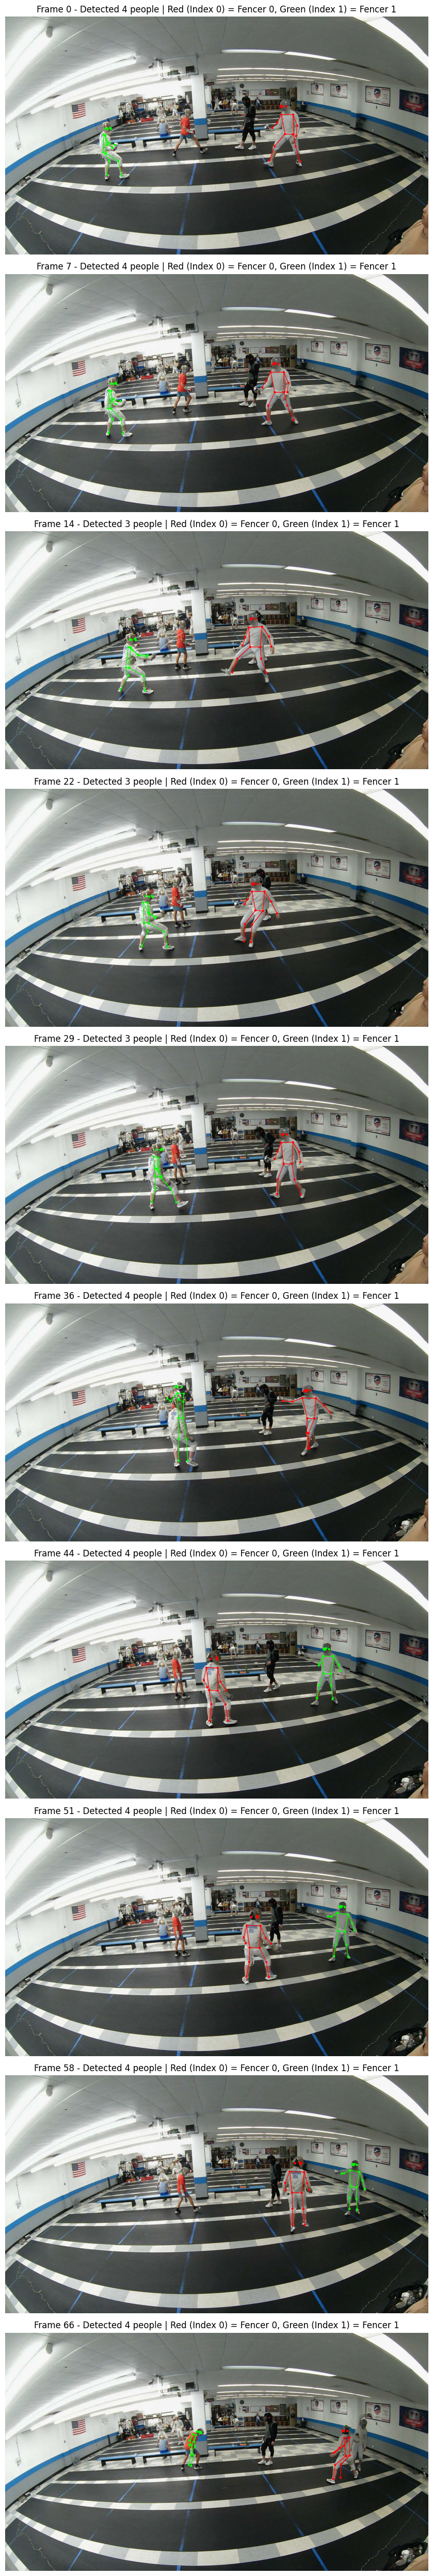


SUMMARY
Total frames analyzed: 10
Frame    0: Detected 4 people
Frame    7: Detected 4 people
Frame   14: Detected 3 people
Frame   22: Detected 3 people
Frame   29: Detected 3 people
Frame   36: Detected 4 people
Frame   44: Detected 4 people
Frame   51: Detected 4 people
Frame   58: Detected 4 people
Frame   66: Detected 4 people


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

def visualize_fencer_keypoints(video_path, sample_frames=10, max_display=5):
    """
    Extract and visualize YOLO pose keypoints for the two fencers (index 0 and 1)
    
    Args:
        video_path: Path to the fencing video (avi format)
        sample_frames: Number of frames to sample from the video
        max_display: Maximum number of frames to display
    """
    
    # Load YOLOv8 pose model
    print("Loading YOLO pose model...")
    model = YOLO('yolov8n-pose.pt')  # Use nano model for speed, can upgrade to yolov8s-pose.pt or yolov8m-pose.pt
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"Video: {total_frames} frames at {fps:.2f} FPS")
    
    # Sample frame indices evenly throughout the video
    frame_indices = np.linspace(0, total_frames - 1, sample_frames, dtype=int)
    
    # Collect frames and keypoints
    frames_data = []
    
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        
        if not ret:
            print(f"Could not read frame {idx}")
            continue
        
        # Run YOLO detection
        results = model(frame, verbose=False)
        
        # Extract keypoints for person index 0 and 1
        if len(results) > 0 and results[0].keypoints is not None:
            keypoints = results[0].keypoints.xy.cpu().numpy()  # Shape: (num_people, 17, 2)
            
            # Store frame data
            frames_data.append({
                'frame_idx': idx,
                'frame': frame.copy(),
                'keypoints': keypoints,
                'num_people': len(keypoints)
            })
    
    cap.release()
    
    # Visualize results
    num_display = min(max_display, len(frames_data))
    fig, axes = plt.subplots(num_display, 1, figsize=(15, 5 * num_display))
    
    if num_display == 1:
        axes = [axes]
    
    # COCO keypoint connections for skeleton
    skeleton = [
        [16, 14], [14, 12], [17, 15], [15, 13], [12, 13],  # Head to shoulders
        [6, 12], [7, 13], [6, 7],  # Shoulders to hips
        [6, 8], [8, 10], [7, 9], [9, 11],  # Arms
        [12, 14], [14, 16], [13, 15], [15, 17]  # Legs
    ]
    
    # Colors for each fencer
    colors = [(255, 0, 0), (0, 255, 0)]  # Red for index 0, Green for index 1
    color_names = ['Red (Index 0)', 'Green (Index 1)']
    
    for plot_idx, data in enumerate(frames_data[:num_display]):
        frame = data['frame']
        keypoints = data['keypoints']
        frame_idx = data['frame_idx']
        
        # Convert BGR to RGB for matplotlib
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Draw keypoints and skeleton for index 0 and 1
        for person_idx in range(min(2, len(keypoints))):
            kpts = keypoints[person_idx]
            color = colors[person_idx]
            
            # Draw skeleton connections
            for connection in skeleton:
                pt1_idx, pt2_idx = connection[0] - 1, connection[1] - 1  # COCO uses 1-based indexing
                if pt1_idx < len(kpts) and pt2_idx < len(kpts):
                    pt1 = kpts[pt1_idx]
                    pt2 = kpts[pt2_idx]
                    
                    # Only draw if both points are detected (confidence > 0)
                    if pt1[0] > 0 and pt1[1] > 0 and pt2[0] > 0 and pt2[1] > 0:
                        cv2.line(frame_rgb, 
                                (int(pt1[0]), int(pt1[1])), 
                                (int(pt2[0]), int(pt2[1])), 
                                color, 2)
            
            # Draw keypoints
            for kpt in kpts:
                if kpt[0] > 0 and kpt[1] > 0:  # Only draw if detected
                    cv2.circle(frame_rgb, (int(kpt[0]), int(kpt[1])), 5, color, -1)
        
        # Plot
        axes[plot_idx].imshow(frame_rgb)
        axes[plot_idx].set_title(f'Frame {frame_idx} - Detected {data["num_people"]} people | {color_names[0]} = Fencer 0, {color_names[1]} = Fencer 1')
        axes[plot_idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('fencer_keypoints_visualization.png', dpi=150, bbox_inches='tight')
    print(f"\nVisualization saved as 'fencer_keypoints_visualization.png'")
    plt.show()
    
    # Summary
    print(f"\n{'='*60}")
    print(f"SUMMARY")
    print(f"{'='*60}")
    print(f"Total frames analyzed: {len(frames_data)}")
    for i, data in enumerate(frames_data):
        print(f"Frame {data['frame_idx']:4d}: Detected {data['num_people']} people")
    
    return frames_data


# Example usage
if __name__ == "__main__":
    # Set your video path here
    video_path = "./training_data/20251017_203917_phrase10/20251017_203917_phrase10.avi"
    
    # Check if file exists
    if not os.path.exists(video_path):
        print(f"Error: Video file not found at {video_path}")
        print("Please update the video_path variable with your actual video path")
    else:
        # Run visualization
        results = visualize_fencer_keypoints(
            video_path=video_path,
            sample_frames=10,  # Sample 10 frames from the video
            max_display=50      # Display up to 5 frames
        )

In [4]:
import cv2
import numpy as np
import pandas as pd
import os
from pathlib import Path
from ultralytics import YOLO
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


def fill_with_linear_regression(data, c):
    """
    Fill NaN values using linear regression from neighboring valid points
    """
    data = np.array(data)
    valid_mask = ~np.isnan(data)
    
    if not valid_mask.any():
        return data
    
    valid_indices = np.where(valid_mask)[0]
    valid_values = data[valid_mask]
    
    if len(valid_indices) == 1:
        # Only one valid point, fill all with that value
        return np.full_like(data, valid_values[0])
    
    # Interpolate using linear regression
    result = data.copy()
    invalid_indices = np.where(~valid_mask)[0]
    
    for idx in invalid_indices:
        # Find nearest valid points before and after
        before_mask = valid_indices < idx
        after_mask = valid_indices > idx
        
        if before_mask.any() and after_mask.any():
            # Interpolate between two points
            before_idx = valid_indices[before_mask][-1]
            after_idx = valid_indices[after_mask][0]
            
            # Linear interpolation
            t = (idx - before_idx) / (after_idx - before_idx)
            result[idx] = valid_values[before_mask][-1] * (1 - t) + valid_values[after_mask][0] * t
        elif before_mask.any():
            # Extrapolate from before
            result[idx] = valid_values[before_mask][-1]
        elif after_mask.any():
            # Extrapolate from after
            result[idx] = valid_values[after_mask][0]
    
    return result


def extract_tracks_from_video(video_path, model):
    """
    Extract YOLO pose tracks from video
    Returns: list of tracks per frame
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    tracks_per_frame = []
    
    # Use YOLO tracking to maintain consistent IDs
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Run tracking
        results = model.track(frame, persist=True, verbose=False)
        
        frame_tracks = []
        if len(results) > 0 and results[0].boxes is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            if results[0].keypoints is not None:
                keypoints = results[0].keypoints.xy.cpu().numpy()
                
                # Get track IDs if available
                if results[0].boxes.id is not None:
                    track_ids = results[0].boxes.id.cpu().numpy().astype(int)
                else:
                    track_ids = list(range(len(boxes)))
                
                for i, (box, kpts, track_id) in enumerate(zip(boxes, keypoints, track_ids)):
                    frame_tracks.append({
                        'box': box,
                        'keypoints': kpts,
                        'track_id': track_id
                    })
        
        tracks_per_frame.append(frame_tracks)
    
    cap.release()
    return tracks_per_frame


def process_video_and_extract_data(tracks_per_frame):
    """
    Process tracks and extract normalized keypoint data
    Ensures consistent left/right fencer assignment and foot swapping
    """
    left_xdata = {k: [] for k in range(17)}
    left_ydata = {k: [] for k in range(17)}
    right_xdata = {k: [] for k in range(17)}
    right_ydata = {k: [] for k in range(17)}
    video_angle = ''
    c = None
    
    # Find the first frame with keypoints for both tracks
    for tracks in tracks_per_frame:
        if len(tracks) >= 2 and all('keypoints' in t for t in tracks[:2]):
            track0, track1 = tracks[0], tracks[1]
            
            # Check if keypoints are valid
            if (len(track0['keypoints']) >= 17 and len(track1['keypoints']) >= 17 and
                track0['keypoints'][15][0] > 0 and track0['keypoints'][16][0] > 0 and
                track1['keypoints'][15][0] > 0 and track1['keypoints'][16][0] > 0):
                
                values = [
                    track0['keypoints'][15][0], track0['keypoints'][16][0],
                    track1['keypoints'][15][0], track1['keypoints'][16][0]
                ]
                sorted_values = sorted(values, reverse=True)
                b = sorted_values[1]
                a = sorted_values[2]
                c = abs((b - a) / 4)
                
                # Calculate video_angle based on box areas
                left_box_area = (track0['box'][2] - track0['box'][0]) * (track0['box'][3] - track0['box'][1])
                right_box_area = (track1['box'][2] - track1['box'][0]) * (track1['box'][3] - track1['box'][1])
                
                if left_box_area >= 1.75 * right_box_area:
                    video_angle = 'left'
                elif right_box_area >= 1.75 * left_box_area:
                    video_angle = 'right'
                else:
                    video_angle = 'middle'
                break
    
    if c is None:
        raise ValueError("No valid frame with keypoints for both tracks found in the video")
    
    # Extract data for all frames
    for tracks in tracks_per_frame:
        try:
            if len(tracks) < 2 or not all('keypoints' in t for t in tracks[:2]):
                # No valid tracks, append NaN
                for j in range(17):
                    left_xdata[j].append(np.nan)
                    left_ydata[j].append(np.nan)
                    right_xdata[j].append(np.nan)
                    right_ydata[j].append(np.nan)
                continue
            
            # Get center x of bounding boxes to determine left vs right
            center_x0 = (tracks[0]['box'][0] + tracks[0]['box'][2]) / 2
            center_x1 = (tracks[1]['box'][0] + tracks[1]['box'][2]) / 2
            
            left_track = tracks[0] if center_x0 < center_x1 else tracks[1]
            right_track = tracks[1] if center_x0 < center_x1 else tracks[0]
            
            # Process each fencer
            for track, xdata, ydata, is_left in [(left_track, left_xdata, left_ydata, True),
                                                   (right_track, right_xdata, right_ydata, False)]:
                keypoints = track['keypoints']
                
                if len(keypoints) < 17:
                    for j in range(17):
                        xdata[j].append(np.nan)
                        ydata[j].append(np.nan)
                    continue
                
                # Swap keypoints to ensure consistency
                # For left fencer: left side should have smaller x values
                # For right fencer: right side should have larger x values
                swapped = keypoints.copy()
                
                # Pairs to potentially swap: (left_keypoint, right_keypoint)
                pairs = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]
                
                for pair in pairs:
                    kp1, kp2 = pair
                    if kp1 >= len(keypoints) or kp2 >= len(keypoints):
                        continue
                    
                    # For left fencer: if left keypoint has larger x, swap
                    if is_left and keypoints[kp1][0] > keypoints[kp2][0]:
                        swapped[kp1], swapped[kp2] = keypoints[kp2].copy(), keypoints[kp1].copy()
                    # For right fencer: if right keypoint has smaller x, swap
                    elif not is_left and keypoints[kp1][0] < keypoints[kp2][0]:
                        swapped[kp1], swapped[kp2] = keypoints[kp2].copy(), keypoints[kp1].copy()
                
                # Store normalized coordinates
                for j in range(17):
                    if swapped[j][0] > 0 and swapped[j][1] > 0:  # Valid keypoint
                        xdata[j].append(swapped[j][0] / c)
                        ydata[j].append(swapped[j][1] / c)
                    else:
                        xdata[j].append(np.nan)
                        ydata[j].append(np.nan)
                        
        except Exception as e:
            # Error processing frame, append NaN
            for j in range(17):
                left_xdata[j].append(np.nan)
                left_ydata[j].append(np.nan)
                right_xdata[j].append(np.nan)
                right_ydata[j].append(np.nan)
            continue
    
    # Apply linear regression to fill gaps
    for k in range(17):
        left_xdata[k] = fill_with_linear_regression(left_xdata[k], c).tolist()
        left_ydata[k] = fill_with_linear_regression(left_ydata[k], c).tolist()
        right_xdata[k] = fill_with_linear_regression(right_xdata[k], c).tolist()
        right_ydata[k] = fill_with_linear_regression(right_ydata[k], c).tolist()
    
    return left_xdata, left_ydata, right_xdata, right_ydata, c, video_angle


def save_keypoints_to_excel(left_xdata, left_ydata, right_xdata, right_ydata, output_path):
    """
    Save keypoint data to Excel file with 4 sheets
    """
    # Convert to DataFrames
    df_left_x = pd.DataFrame(left_xdata)
    df_left_y = pd.DataFrame(left_ydata)
    df_right_x = pd.DataFrame(right_xdata)
    df_right_y = pd.DataFrame(right_ydata)
    
    # Set column names to keypoint indices
    keypoint_names = [f'kp_{i}' for i in range(17)]
    df_left_x.columns = keypoint_names
    df_left_y.columns = keypoint_names
    df_right_x.columns = keypoint_names
    df_right_y.columns = keypoint_names
    
    # Save to Excel with multiple sheets
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        df_left_x.to_excel(writer, sheet_name='left_x', index=False)
        df_left_y.to_excel(writer, sheet_name='left_y', index=False)
        df_right_x.to_excel(writer, sheet_name='right_x', index=False)
        df_right_y.to_excel(writer, sheet_name='right_y', index=False)


def process_all_videos(base_path, model):
    """
    Process all videos in the training_data folder structure
    """
    base_path = Path(base_path)
    
    # Find all subdirectories
    subdirs = [d for d in base_path.iterdir() if d.is_dir()]
    
    print(f"Found {len(subdirs)} subdirectories to process")
    
    results_summary = []
    
    for subdir in tqdm(subdirs, desc="Processing subdirectories"):
        # Find all .avi files in this subdirectory
        video_files = list(subdir.glob("*.avi"))
        
        if not video_files:
            print(f"  No .avi files found in {subdir.name}")
            continue
        
        for video_path in video_files:
            print(f"\n  Processing: {video_path.name}")
            
            try:
                # Extract tracks
                print("    Extracting tracks...")
                tracks_per_frame = extract_tracks_from_video(str(video_path), model)
                
                # Process data
                print("    Processing keypoints...")
                left_xdata, left_ydata, right_xdata, right_ydata, c, video_angle = \
                    process_video_and_extract_data(tracks_per_frame)
                
                # Save to Excel
                output_filename = video_path.stem + "_keypoints.xlsx"
                output_path = subdir / output_filename
                
                print("    Saving to Excel...")
                save_keypoints_to_excel(left_xdata, left_ydata, right_xdata, right_ydata, str(output_path))
                
                results_summary.append({
                    'subdir': subdir.name,
                    'video': video_path.name,
                    'output': output_filename,
                    'frames': len(left_xdata[0]),
                    'c_value': c,
                    'video_angle': video_angle,
                    'status': 'Success'
                })
                
                print(f"    ✓ Saved to {output_filename}")
                print(f"    Frames: {len(left_xdata[0])}, c={c:.2f}, angle={video_angle}")
                
            except Exception as e:
                print(f"    ✗ Error: {str(e)}")
                results_summary.append({
                    'subdir': subdir.name,
                    'video': video_path.name,
                    'output': 'N/A',
                    'frames': 0,
                    'c_value': 0,
                    'video_angle': 'N/A',
                    'status': f'Error: {str(e)}'
                })
    
    # Save summary
    summary_df = pd.DataFrame(results_summary)
    summary_path = base_path / "processing_summary.csv"
    summary_df.to_csv(summary_path, index=False)
    
    print("\n" + "="*60)
    print("PROCESSING COMPLETE")
    print("="*60)
    print(f"Total videos processed: {len(results_summary)}")
    print(f"Successful: {sum(1 for r in results_summary if r['status'] == 'Success')}")
    print(f"Failed: {sum(1 for r in results_summary if r['status'] != 'Success')}")
    print(f"\nSummary saved to: {summary_path}")
    
    return summary_df


# Main execution
if __name__ == "__main__":
    # Configuration
    BASE_PATH = "./training_data"
    
    # Load YOLO model
    print("Loading YOLO pose model...")
    model = YOLO('yolov8m-pose.pt')  # Using medium model for better accuracy
    
    # Process all videos
    summary = process_all_videos(BASE_PATH, model)
    
    # Display summary
    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)
    print(summary.to_string(index=False))

Loading YOLO pose model...
Found 39 subdirectories to process


Processing subdirectories:   0%|          | 0/39 [00:00<?, ?it/s]


  Processing: 20251017_205306_phrase35.avi
    Extracting tracks...
requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.7 MB ? eta -:--:--
   ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.7 MB 1.5 MB/s eta 0:00:02
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.6/1.7 MB 8.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━ 1.0/1.7 MB 14.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.5 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 4.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect




[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip


    Processing keypoints...
    Saving to Excel...


Processing subdirectories:   3%|▎         | 1/39 [00:10<06:48, 10.75s/it]

    ✓ Saved to 20251017_205306_phrase35_keypoints.xlsx
    Frames: 97, c=163.22, angle=middle

  Processing: 20251017_204004_phrase12.avi
    Extracting tracks...


Processing subdirectories:   5%|▌         | 2/39 [00:13<03:54,  6.33s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204004_phrase12_keypoints.xlsx
    Frames: 53, c=170.87, angle=middle

  Processing: 20251017_203904_phrase09.avi
    Extracting tracks...


Processing subdirectories:   8%|▊         | 3/39 [00:15<02:27,  4.10s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_203904_phrase09_keypoints.xlsx
    Frames: 23, c=166.81, angle=middle

  Processing: 20251017_203917_phrase10.avi
    Extracting tracks...


Processing subdirectories:  10%|█         | 4/39 [00:19<02:22,  4.07s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_203917_phrase10_keypoints.xlsx
    Frames: 67, c=80.14, angle=middle

  Processing: 20251017_204513_phrase23.avi
    Extracting tracks...


Processing subdirectories:  13%|█▎        | 5/39 [00:20<01:45,  3.11s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204513_phrase23_keypoints.xlsx
    Frames: 23, c=171.61, angle=middle

  Processing: 20251017_204746_phrase30.avi
    Extracting tracks...


Processing subdirectories:  15%|█▌        | 6/39 [00:26<02:13,  4.04s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204746_phrase30_keypoints.xlsx
    Frames: 100, c=160.24, angle=middle

  Processing: 20251017_203756_phrase05.avi
    Extracting tracks...


Processing subdirectories:  18%|█▊        | 7/39 [00:28<01:45,  3.29s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_203756_phrase05_keypoints.xlsx
    Frames: 28, c=163.54, angle=middle

  Processing: 20251017_204444_phrase22.avi
    Extracting tracks...


Processing subdirectories:  21%|██        | 8/39 [00:38<02:53,  5.59s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204444_phrase22_keypoints.xlsx
    Frames: 180, c=169.19, angle=middle

  Processing: 20251017_203935_phrase11.avi
    Extracting tracks...


Processing subdirectories:  23%|██▎       | 9/39 [00:48<03:22,  6.76s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_203935_phrase11_keypoints.xlsx
    Frames: 156, c=172.47, angle=middle

  Processing: 20251017_205437_phrase40.avi
    Extracting tracks...
    Processing keypoints...
    Saving to Excel...


Processing subdirectories:  26%|██▌       | 10/39 [00:55<03:22,  6.98s/it]

    ✓ Saved to 20251017_205437_phrase40_keypoints.xlsx
    Frames: 129, c=178.21, angle=middle

  Processing: 20251017_205340_phrase37.avi
    Extracting tracks...


Processing subdirectories:  28%|██▊       | 11/39 [01:02<03:15,  6.98s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_205340_phrase37_keypoints.xlsx
    Frames: 123, c=161.96, angle=middle

  Processing: 20251017_204733_phrase29.avi
    Extracting tracks...


Processing subdirectories:  31%|███       | 12/39 [01:04<02:24,  5.34s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204733_phrase29_keypoints.xlsx
    Frames: 26, c=167.80, angle=middle

  Processing: 20251017_205214_phrase32.avi
    Extracting tracks...


Processing subdirectories:  33%|███▎      | 13/39 [01:10<02:23,  5.52s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_205214_phrase32_keypoints.xlsx
    Frames: 103, c=159.42, angle=middle

  Processing: 20251017_204812_phrase31.avi
    Extracting tracks...


Processing subdirectories:  36%|███▌      | 14/39 [01:12<01:53,  4.52s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204812_phrase31_keypoints.xlsx
    Frames: 37, c=163.28, angle=middle

  Processing: 20251017_204036_phrase14.avi
    Extracting tracks...


Processing subdirectories:  38%|███▊      | 15/39 [01:14<01:29,  3.72s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204036_phrase14_keypoints.xlsx
    Frames: 31, c=54.77, angle=left

  Processing: 20251017_204409_phrase20.avi
    Extracting tracks...


Processing subdirectories:  41%|████      | 16/39 [01:16<01:17,  3.37s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204409_phrase20_keypoints.xlsx
    Frames: 43, c=170.17, angle=middle

  Processing: 20251017_204425_phrase21.avi
    Extracting tracks...


Processing subdirectories:  44%|████▎     | 17/39 [01:19<01:09,  3.16s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204425_phrase21_keypoints.xlsx
    Frames: 45, c=164.85, angle=middle

  Processing: 20251017_204107_phrase16.avi
    Extracting tracks...


Processing subdirectories:  46%|████▌     | 18/39 [01:23<01:11,  3.41s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204107_phrase16_keypoints.xlsx
    Frames: 67, c=168.95, angle=middle

  Processing: 20251017_203728_phrase04.avi
    Extracting tracks...
    Processing keypoints...
    Saving to Excel...


Processing subdirectories:  49%|████▊     | 19/39 [01:36<02:06,  6.33s/it]

    ✓ Saved to 20251017_203728_phrase04_keypoints.xlsx
    Frames: 220, c=165.31, angle=middle

  Processing: 20251017_205401_phrase38.avi
    Extracting tracks...


Processing subdirectories:  51%|█████▏    | 20/39 [01:38<01:33,  4.93s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_205401_phrase38_keypoints.xlsx
    Frames: 29, c=157.39, angle=middle

  Processing: 20251017_205232_phrase33.avi
    Extracting tracks...


Processing subdirectories:  54%|█████▍    | 21/39 [01:39<01:10,  3.90s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_205232_phrase33_keypoints.xlsx
    Frames: 25, c=159.53, angle=middle

  Processing: 20251017_204241_phrase19.avi
    Extracting tracks...


Processing subdirectories:  56%|█████▋    | 22/39 [01:41<00:55,  3.25s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204241_phrase19_keypoints.xlsx
    Frames: 29, c=173.83, angle=middle

  Processing: 20251017_205422_phrase39.avi
    Extracting tracks...


Processing subdirectories:  59%|█████▉    | 23/39 [01:46<00:58,  3.66s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_205422_phrase39_keypoints.xlsx
    Frames: 81, c=157.49, angle=middle

  Processing: 20251017_205324_phrase36.avi
    Extracting tracks...


Processing subdirectories:  62%|██████▏   | 24/39 [01:51<01:01,  4.13s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_205324_phrase36_keypoints.xlsx
    Frames: 92, c=147.26, angle=middle

  Processing: 20251017_204617_phrase26.avi
    Extracting tracks...
    Processing keypoints...
    Saving to Excel...


Processing subdirectories:  64%|██████▍   | 25/39 [02:04<01:35,  6.81s/it]

    ✓ Saved to 20251017_204617_phrase26_keypoints.xlsx
    Frames: 232, c=175.72, angle=middle

  Processing: 20251017_204604_phrase25.avi
    Extracting tracks...


Processing subdirectories:  67%|██████▋   | 26/39 [02:05<01:05,  5.04s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204604_phrase25_keypoints.xlsx
    Frames: 15, c=159.85, angle=middle

  Processing: 20251017_204713_phrase28.avi
    Extracting tracks...


Processing subdirectories:  69%|██████▉   | 27/39 [02:07<00:49,  4.13s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204713_phrase28_keypoints.xlsx
    Frames: 34, c=176.54, angle=middle

  Processing: 20251017_205243_phrase34.avi
    Extracting tracks...


Processing subdirectories:  72%|███████▏  | 28/39 [02:13<00:50,  4.57s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_205243_phrase34_keypoints.xlsx
    Frames: 99, c=156.22, angle=middle

  Processing: 20251017_204129_phrase17.avi
    Extracting tracks...


Processing subdirectories:  74%|███████▍  | 29/39 [02:14<00:36,  3.64s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204129_phrase17_keypoints.xlsx
    Frames: 25, c=172.51, angle=middle

  Processing: 20251017_205455_phrase41.avi
    Extracting tracks...


Processing subdirectories:  77%|███████▋  | 30/39 [02:18<00:34,  3.84s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_205455_phrase41_keypoints.xlsx
    Frames: 75, c=161.10, angle=middle

  Processing: 20251017_203809_phrase06.avi
    Extracting tracks...


Processing subdirectories:  79%|███████▉  | 31/39 [02:20<00:26,  3.27s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_203809_phrase06_keypoints.xlsx
    Frames: 32, c=165.64, angle=middle

  Processing: 20251017_203706_phrase03.avi
    Extracting tracks...


Processing subdirectories:  82%|████████▏ | 32/39 [02:30<00:36,  5.17s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_203706_phrase03_keypoints.xlsx
    Frames: 161, c=163.63, angle=middle

  Processing: 20251017_204049_phrase15.avi
    Extracting tracks...


Processing subdirectories:  85%|████████▍ | 33/39 [02:31<00:24,  4.03s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204049_phrase15_keypoints.xlsx
    Frames: 22, c=130.63, angle=left

  Processing: 20251017_203837_phrase08.avi
    Extracting tracks...


Processing subdirectories:  87%|████████▋ | 34/39 [02:34<00:17,  3.56s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_203837_phrase08_keypoints.xlsx
    Frames: 40, c=108.68, angle=middle

  Processing: 20251017_204142_phrase18.avi
    Extracting tracks...


Processing subdirectories:  90%|████████▉ | 35/39 [02:40<00:17,  4.36s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204142_phrase18_keypoints.xlsx
    Frames: 105, c=326.60, angle=middle

  Processing: 20251017_204548_phrase24.avi
    Extracting tracks...


Processing subdirectories:  92%|█████████▏| 36/39 [02:42<00:11,  3.69s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204548_phrase24_keypoints.xlsx
    Frames: 36, c=119.39, angle=middle

  Processing: 20251017_203820_phrase07.avi
    Extracting tracks...


Processing subdirectories:  95%|█████████▍| 37/39 [02:45<00:06,  3.45s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_203820_phrase07_keypoints.xlsx
    Frames: 49, c=171.10, angle=middle

  Processing: 20251017_204022_phrase13.avi
    Extracting tracks...


Processing subdirectories:  97%|█████████▋| 38/39 [02:47<00:02,  2.90s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204022_phrase13_keypoints.xlsx
    Frames: 26, c=125.19, angle=middle

  Processing: 20251017_204645_phrase27.avi
    Extracting tracks...


Processing subdirectories: 100%|██████████| 39/39 [02:51<00:00,  4.40s/it]

    Processing keypoints...
    Saving to Excel...
    ✓ Saved to 20251017_204645_phrase27_keypoints.xlsx
    Frames: 75, c=162.29, angle=middle

PROCESSING COMPLETE
Total videos processed: 39
Successful: 39
Failed: 0

Summary saved to: training_data/processing_summary.csv

RESULTS SUMMARY
                  subdir                        video                                  output  frames    c_value video_angle  status
20251017_205306_phrase35 20251017_205306_phrase35.avi 20251017_205306_phrase35_keypoints.xlsx      97 163.223923      middle Success
20251017_204004_phrase12 20251017_204004_phrase12.avi 20251017_204004_phrase12_keypoints.xlsx      53 170.873169      middle Success
20251017_203904_phrase09 20251017_203904_phrase09.avi 20251017_203904_phrase09_keypoints.xlsx      23 166.806564      middle Success
20251017_203917_phrase10 20251017_203917_phrase10.avi 20251017_203917_phrase10_keypoints.xlsx      67  80.142990      middle Success
20251017_204513_phrase23 20251017_204513_phr

In [7]:
import cv2
import numpy as np
import pandas as pd
import os
from pathlib import Path
from tqdm import tqdm


def load_keypoints_from_excel(excel_path):
    """
    Load keypoint data from Excel file with 4 sheets
    Returns: (left_xdata, left_ydata, right_xdata, right_ydata)
    """
    df_left_x = pd.read_excel(excel_path, sheet_name='left_x')
    df_left_y = pd.read_excel(excel_path, sheet_name='left_y')
    df_right_x = pd.read_excel(excel_path, sheet_name='right_x')
    df_right_y = pd.read_excel(excel_path, sheet_name='right_y')
    
    # Convert to dictionary format {keypoint_idx: [values]}
    left_xdata = {i: df_left_x[f'kp_{i}'].tolist() for i in range(17)}
    left_ydata = {i: df_left_y[f'kp_{i}'].tolist() for i in range(17)}
    right_xdata = {i: df_right_x[f'kp_{i}'].tolist() for i in range(17)}
    right_ydata = {i: df_right_y[f'kp_{i}'].tolist() for i in range(17)}
    
    return left_xdata, left_ydata, right_xdata, right_ydata


def get_skeleton_connections():
    """
    Define COCO skeleton connections for drawing
    Returns list of (start_kp, end_kp) tuples
    """
    # COCO keypoint skeleton (0-indexed)
    skeleton = [
        # Head and torso
        (0, 1), (0, 2),  # nose to eyes
        (1, 3), (2, 4),  # eyes to ears
        (0, 5), (0, 6),  # nose to shoulders
        (5, 6),  # shoulders
        (5, 7), (7, 9),  # left arm
        (6, 8), (8, 10),  # right arm
        (5, 11), (6, 12),  # shoulders to hips
        (11, 12),  # hips
        # Legs
        (11, 13), (13, 15),  # left leg
        (12, 14), (14, 16),  # right leg
    ]
    return skeleton


def denormalize_keypoint(x, y, c):
    """
    Convert normalized keypoint back to pixel coordinates
    """
    return int(x * c), int(y * c)


def draw_keypoints_on_frame(frame, left_xdata, left_ydata, right_xdata, right_ydata, 
                            frame_idx, c, draw_skeleton=True, draw_labels=True):
    """
    Draw keypoints and skeleton on a single frame
    
    Args:
        frame: OpenCV frame (BGR)
        left_xdata, left_ydata: Left fencer keypoint data
        right_xdata, right_ydata: Right fencer keypoint data
        frame_idx: Current frame index
        c: Normalization constant
        draw_skeleton: Whether to draw skeleton connections
        draw_labels: Whether to draw keypoint labels
    """
    frame_display = frame.copy()
    skeleton = get_skeleton_connections()
    
    # Colors: Red for left fencer, Green for right fencer
    colors = {
        'left': (0, 0, 255),    # Red (BGR)
        'right': (0, 255, 0),   # Green (BGR)
    }
    
    # Process both fencers
    for fencer_name, xdata, ydata, color in [
        ('left', left_xdata, left_ydata, colors['left']),
        ('right', right_xdata, right_ydata, colors['right'])
    ]:
        # Check if frame_idx is within bounds
        if frame_idx >= len(xdata[0]):
            continue
        
        # Get keypoints for this frame
        keypoints = []
        for i in range(17):
            x = xdata[i][frame_idx]
            y = ydata[i][frame_idx]
            
            # Check if valid (not NaN)
            if not np.isnan(x) and not np.isnan(y):
                px, py = denormalize_keypoint(x, y, c)
                keypoints.append((px, py, True))  # (x, y, is_valid)
            else:
                keypoints.append((0, 0, False))
        
        # Draw skeleton connections
        if draw_skeleton:
            for start_idx, end_idx in skeleton:
                if keypoints[start_idx][2] and keypoints[end_idx][2]:  # Both points valid
                    pt1 = (keypoints[start_idx][0], keypoints[start_idx][1])
                    pt2 = (keypoints[end_idx][0], keypoints[end_idx][1])
                    cv2.line(frame_display, pt1, pt2, color, 2, cv2.LINE_AA)
        
        # Draw keypoints
        for i, (px, py, is_valid) in enumerate(keypoints):
            if is_valid:
                # Draw larger circles for ankle keypoints (15, 16)
                radius = 8 if i in [15, 16] else 5
                cv2.circle(frame_display, (px, py), radius, color, -1, cv2.LINE_AA)
                cv2.circle(frame_display, (px, py), radius + 1, (255, 255, 255), 1, cv2.LINE_AA)
                
                # Draw keypoint labels
                if draw_labels:
                    label = str(i)
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    font_scale = 0.3
                    thickness = 1
                    
                    # Get text size for background
                    (text_width, text_height), baseline = cv2.getTextSize(
                        label, font, font_scale, thickness
                    )
                    
                    # Draw background rectangle
                    cv2.rectangle(
                        frame_display,
                        (px - 2, py - text_height - 4),
                        (px + text_width + 2, py + 2),
                        (0, 0, 0),
                        -1
                    )
                    
                    # Draw text
                    cv2.putText(
                        frame_display,
                        label,
                        (px, py - 2),
                        font,
                        font_scale,
                        (255, 255, 255),
                        thickness,
                        cv2.LINE_AA
                    )
    
    # Add frame number and legend
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame_display, f'Frame: {frame_idx}', (10, 30), 
                font, 0.8, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(frame_display, f'Frame: {frame_idx}', (10, 30), 
                font, 0.8, (0, 0, 0), 1, cv2.LINE_AA)
    
    # Legend
    legend_y = 60
    cv2.putText(frame_display, 'Left Fencer', (10, legend_y), 
                font, 0.6, colors['left'], 2, cv2.LINE_AA)
    cv2.putText(frame_display, 'Right Fencer', (10, legend_y + 25), 
                font, 0.6, colors['right'], 2, cv2.LINE_AA)
    
    return frame_display


def create_overlay_video(video_path, excel_path, output_path, c_value=None, 
                         draw_skeleton=True, draw_labels=True):
    """
    Create overlay video with keypoints drawn on original video
    
    Args:
        video_path: Path to original .avi video
        excel_path: Path to keypoints Excel file
        output_path: Path for output video
        c_value: Normalization constant (if None, will estimate from data)
        draw_skeleton: Whether to draw skeleton connections
        draw_labels: Whether to draw keypoint index labels
    """
    # Load keypoints
    print(f"Loading keypoints from {Path(excel_path).name}...")
    left_xdata, left_ydata, right_xdata, right_ydata = load_keypoints_from_excel(excel_path)
    
    # Estimate c_value if not provided
    if c_value is None:
        # Find first valid frame to estimate c
        for frame_idx in range(len(left_xdata[0])):
            x15_left = left_xdata[15][frame_idx]
            x16_left = left_xdata[16][frame_idx]
            x15_right = right_xdata[15][frame_idx]
            x16_right = right_xdata[16][frame_idx]
            
            if not any(np.isnan([x15_left, x16_left, x15_right, x16_right])):
                # Use the normalization formula from original code
                values = [x15_left, x16_left, x15_right, x16_right]
                sorted_values = sorted(values, reverse=True)
                b = sorted_values[1]
                a = sorted_values[2]
                # Since values are already normalized, estimate original c
                # This is approximate - ideally c should be stored in the Excel
                c_value = 100  # Default reasonable value
                print(f"  Estimated c_value: {c_value}")
                break
        
        if c_value is None:
            c_value = 100  # Fallback default
            print(f"  Using default c_value: {c_value}")
    else:
        print(f"  Using provided c_value: {c_value}")
    
    # Open video
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        raise ValueError(f"Cannot open video: {video_path}")
    
    # Get video properties
    fps = int(cap.get(cv2.cv.CV_CAP_PROP_FPS) if hasattr(cv2, 'cv') else cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_WIDTH) if hasattr(cv2, 'cv') else cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_HEIGHT) if hasattr(cv2, 'cv') else cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT) if hasattr(cv2, 'cv') else cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video properties: {width}x{height} @ {fps} FPS, {total_frames} frames")
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
    
    print(f"Creating overlay video...")
    frame_idx = 0
    
    with tqdm(total=total_frames, desc="Processing frames") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Draw keypoints on frame
            frame_with_keypoints = draw_keypoints_on_frame(
                frame, left_xdata, left_ydata, right_xdata, right_ydata,
                frame_idx, c_value, draw_skeleton, draw_labels
            )
            
            # Write frame
            out.write(frame_with_keypoints)
            
            frame_idx += 1
            pbar.update(1)
    
    # Release resources
    cap.release()
    out.release()
    
    print(f"✓ Overlay video saved to: {output_path}")
    print(f"  Total frames processed: {frame_idx}")


def process_all_overlay_videos(base_path, draw_skeleton=True, draw_labels=True):
    """
    Create overlay videos for all Excel keypoint files in subdirectories
    
    Args:
        base_path: Base path to training_data folder
        draw_skeleton: Whether to draw skeleton connections
        draw_labels: Whether to draw keypoint index labels
    """
    base_path = Path(base_path)
    
    # Find all subdirectories
    subdirs = [d for d in base_path.iterdir() if d.is_dir()]
    
    print(f"Found {len(subdirs)} subdirectories")
    print("="*60)
    
    results = []
    
    for subdir in subdirs:
        print(f"\nProcessing subdirectory: {subdir.name}")
        
        # Find all keypoint Excel files
        excel_files = list(subdir.glob("*_keypoints.xlsx"))
        
        if not excel_files:
            print(f"  No keypoint files found in {subdir.name}")
            continue
        
        for excel_path in excel_files:
            # Find corresponding video file
            video_stem = excel_path.stem.replace('_keypoints', '')
            video_path = subdir / f"{video_stem}.avi"
            
            if not video_path.exists():
                print(f"  Warning: Video not found for {excel_path.name}")
                continue
            
            # Create output path
            output_path = subdir / f"{video_stem}_overlay.mp4"
            
            try:
                create_overlay_video(
                    video_path, excel_path, output_path,
                    c_value=None,  # Auto-estimate
                    draw_skeleton=draw_skeleton,
                    draw_labels=draw_labels
                )
                
                results.append({
                    'subdir': subdir.name,
                    'video': video_path.name,
                    'output': output_path.name,
                    'status': 'Success'
                })
                
            except Exception as e:
                print(f"  ✗ Error processing {excel_path.name}: {str(e)}")
                results.append({
                    'subdir': subdir.name,
                    'video': video_path.name,
                    'output': 'N/A',
                    'status': f'Error: {str(e)}'
                })
    
    # Print summary
    print("\n" + "="*60)
    print("OVERLAY VIDEO GENERATION COMPLETE")
    print("="*60)
    print(f"Total processed: {len(results)}")
    print(f"Successful: {sum(1 for r in results if r['status'] == 'Success')}")
    print(f"Failed: {sum(1 for r in results if r['status'] != 'Success')}")
    
    return results


def create_single_overlay_video(video_path, excel_path, output_path=None, 
                                c_value=170, draw_skeleton=True, draw_labels=False):
    """
    Convenience function to create a single overlay video
    
    Args:
        video_path: Path to video file
        excel_path: Path to Excel keypoints file
        output_path: Output path (if None, will auto-generate)
        c_value: Normalization constant
        draw_skeleton: Whether to draw skeleton
        draw_labels: Whether to draw keypoint labels
    """
    video_path = Path(video_path)
    excel_path = Path(excel_path)
    
    if output_path is None:
        output_path = video_path.parent / f"{video_path.stem}_overlay.mp4"
    
    create_overlay_video(video_path, excel_path, output_path, c_value, 
                        draw_skeleton, draw_labels)


# Main execution
if __name__ == "__main__":
    # Configuration
    BASE_PATH = "./training_data"
    
    # Option 1: Process all videos in all subdirectories
    print("Processing all videos in training_data...")
    results = process_all_overlay_videos(
        BASE_PATH,
        draw_skeleton=True,   # Set to False to only show keypoints
        draw_labels=False      # Set to True to show keypoint indices
    )
    
    # Option 2: Process a single video (uncomment to use)
    # create_single_overlay_video(
    #     video_path="./recordings/training_data/phrase04/20251017_203728_phrase04.avi",
    #     excel_path="./recordings/training_data/phrase04/20251017_203728_phrase04_keypoints.xlsx",
    #     draw_skeleton=True,
    #     draw_labels=False
    # )

Processing all videos in training_data...
Found 39 subdirectories

Processing subdirectory: 20251017_205306_phrase35
Loading keypoints from 20251017_205306_phrase35_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 97 frames
Creating overlay video...


Processing frames: 100%|██████████| 97/97 [00:02<00:00, 32.83it/s]


✓ Overlay video saved to: training_data/20251017_205306_phrase35/20251017_205306_phrase35_overlay.mp4
  Total frames processed: 97

Processing subdirectory: 20251017_204004_phrase12
Loading keypoints from 20251017_204004_phrase12_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 53 frames
Creating overlay video...


Processing frames: 100%|██████████| 53/53 [00:01<00:00, 33.14it/s]


✓ Overlay video saved to: training_data/20251017_204004_phrase12/20251017_204004_phrase12_overlay.mp4
  Total frames processed: 53

Processing subdirectory: 20251017_203904_phrase09
Loading keypoints from 20251017_203904_phrase09_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 23 frames
Creating overlay video...


Processing frames: 100%|██████████| 23/23 [00:00<00:00, 33.35it/s]


✓ Overlay video saved to: training_data/20251017_203904_phrase09/20251017_203904_phrase09_overlay.mp4
  Total frames processed: 23

Processing subdirectory: 20251017_203917_phrase10
Loading keypoints from 20251017_203917_phrase10_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 67 frames
Creating overlay video...


Processing frames: 100%|██████████| 67/67 [00:01<00:00, 33.55it/s]


✓ Overlay video saved to: training_data/20251017_203917_phrase10/20251017_203917_phrase10_overlay.mp4
  Total frames processed: 67

Processing subdirectory: 20251017_204513_phrase23
Loading keypoints from 20251017_204513_phrase23_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 23 frames
Creating overlay video...


Processing frames: 100%|██████████| 23/23 [00:00<00:00, 33.43it/s]


✓ Overlay video saved to: training_data/20251017_204513_phrase23/20251017_204513_phrase23_overlay.mp4
  Total frames processed: 23

Processing subdirectory: 20251017_204746_phrase30
Loading keypoints from 20251017_204746_phrase30_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 100 frames
Creating overlay video...


Processing frames: 100%|██████████| 100/100 [00:02<00:00, 33.45it/s]


✓ Overlay video saved to: training_data/20251017_204746_phrase30/20251017_204746_phrase30_overlay.mp4
  Total frames processed: 100

Processing subdirectory: 20251017_203756_phrase05
Loading keypoints from 20251017_203756_phrase05_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 28 frames
Creating overlay video...


Processing frames: 100%|██████████| 28/28 [00:00<00:00, 33.51it/s]


✓ Overlay video saved to: training_data/20251017_203756_phrase05/20251017_203756_phrase05_overlay.mp4
  Total frames processed: 28

Processing subdirectory: 20251017_204444_phrase22
Loading keypoints from 20251017_204444_phrase22_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 180 frames
Creating overlay video...


Processing frames: 100%|██████████| 180/180 [00:05<00:00, 33.46it/s]


✓ Overlay video saved to: training_data/20251017_204444_phrase22/20251017_204444_phrase22_overlay.mp4
  Total frames processed: 180

Processing subdirectory: 20251017_203935_phrase11
Loading keypoints from 20251017_203935_phrase11_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 156 frames
Creating overlay video...


Processing frames: 100%|██████████| 156/156 [00:04<00:00, 33.37it/s]


✓ Overlay video saved to: training_data/20251017_203935_phrase11/20251017_203935_phrase11_overlay.mp4
  Total frames processed: 156

Processing subdirectory: 20251017_205437_phrase40
Loading keypoints from 20251017_205437_phrase40_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 129 frames
Creating overlay video...


Processing frames: 100%|██████████| 129/129 [00:03<00:00, 34.04it/s]


✓ Overlay video saved to: training_data/20251017_205437_phrase40/20251017_205437_phrase40_overlay.mp4
  Total frames processed: 129

Processing subdirectory: 20251017_205340_phrase37
Loading keypoints from 20251017_205340_phrase37_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 123 frames
Creating overlay video...


Processing frames: 100%|██████████| 123/123 [00:03<00:00, 34.08it/s]


✓ Overlay video saved to: training_data/20251017_205340_phrase37/20251017_205340_phrase37_overlay.mp4
  Total frames processed: 123

Processing subdirectory: 20251017_204733_phrase29
Loading keypoints from 20251017_204733_phrase29_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 26 frames
Creating overlay video...


Processing frames: 100%|██████████| 26/26 [00:00<00:00, 34.07it/s]


✓ Overlay video saved to: training_data/20251017_204733_phrase29/20251017_204733_phrase29_overlay.mp4
  Total frames processed: 26

Processing subdirectory: 20251017_205214_phrase32
Loading keypoints from 20251017_205214_phrase32_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 103 frames
Creating overlay video...


Processing frames: 100%|██████████| 103/103 [00:03<00:00, 33.81it/s]


✓ Overlay video saved to: training_data/20251017_205214_phrase32/20251017_205214_phrase32_overlay.mp4
  Total frames processed: 103

Processing subdirectory: 20251017_204812_phrase31
Loading keypoints from 20251017_204812_phrase31_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 37 frames
Creating overlay video...


Processing frames: 100%|██████████| 37/37 [00:01<00:00, 34.16it/s]


✓ Overlay video saved to: training_data/20251017_204812_phrase31/20251017_204812_phrase31_overlay.mp4
  Total frames processed: 37

Processing subdirectory: 20251017_204036_phrase14
Loading keypoints from 20251017_204036_phrase14_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 31 frames
Creating overlay video...


Processing frames: 100%|██████████| 31/31 [00:00<00:00, 34.09it/s]


✓ Overlay video saved to: training_data/20251017_204036_phrase14/20251017_204036_phrase14_overlay.mp4
  Total frames processed: 31

Processing subdirectory: 20251017_204409_phrase20
Loading keypoints from 20251017_204409_phrase20_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 43 frames
Creating overlay video...


Processing frames: 100%|██████████| 43/43 [00:01<00:00, 34.01it/s]


✓ Overlay video saved to: training_data/20251017_204409_phrase20/20251017_204409_phrase20_overlay.mp4
  Total frames processed: 43

Processing subdirectory: 20251017_204425_phrase21
Loading keypoints from 20251017_204425_phrase21_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 45 frames
Creating overlay video...


Processing frames: 100%|██████████| 45/45 [00:01<00:00, 33.92it/s]


✓ Overlay video saved to: training_data/20251017_204425_phrase21/20251017_204425_phrase21_overlay.mp4
  Total frames processed: 45

Processing subdirectory: 20251017_204107_phrase16
Loading keypoints from 20251017_204107_phrase16_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 67 frames
Creating overlay video...


Processing frames: 100%|██████████| 67/67 [00:01<00:00, 33.69it/s]


✓ Overlay video saved to: training_data/20251017_204107_phrase16/20251017_204107_phrase16_overlay.mp4
  Total frames processed: 67

Processing subdirectory: 20251017_203728_phrase04
Loading keypoints from 20251017_203728_phrase04_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 220 frames
Creating overlay video...


Processing frames: 100%|██████████| 220/220 [00:06<00:00, 33.42it/s]


✓ Overlay video saved to: training_data/20251017_203728_phrase04/20251017_203728_phrase04_overlay.mp4
  Total frames processed: 220

Processing subdirectory: 20251017_205401_phrase38
Loading keypoints from 20251017_205401_phrase38_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 29 frames
Creating overlay video...


Processing frames: 100%|██████████| 29/29 [00:00<00:00, 34.02it/s]


✓ Overlay video saved to: training_data/20251017_205401_phrase38/20251017_205401_phrase38_overlay.mp4
  Total frames processed: 29

Processing subdirectory: 20251017_205232_phrase33
Loading keypoints from 20251017_205232_phrase33_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 25 frames
Creating overlay video...


Processing frames: 100%|██████████| 25/25 [00:00<00:00, 34.28it/s]


✓ Overlay video saved to: training_data/20251017_205232_phrase33/20251017_205232_phrase33_overlay.mp4
  Total frames processed: 25

Processing subdirectory: 20251017_204241_phrase19
Loading keypoints from 20251017_204241_phrase19_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 29 frames
Creating overlay video...


Processing frames: 100%|██████████| 29/29 [00:00<00:00, 34.14it/s]


✓ Overlay video saved to: training_data/20251017_204241_phrase19/20251017_204241_phrase19_overlay.mp4
  Total frames processed: 29

Processing subdirectory: 20251017_205422_phrase39
Loading keypoints from 20251017_205422_phrase39_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 81 frames
Creating overlay video...


Processing frames: 100%|██████████| 81/81 [00:02<00:00, 33.99it/s]


✓ Overlay video saved to: training_data/20251017_205422_phrase39/20251017_205422_phrase39_overlay.mp4
  Total frames processed: 81

Processing subdirectory: 20251017_205324_phrase36
Loading keypoints from 20251017_205324_phrase36_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 92 frames
Creating overlay video...


Processing frames: 100%|██████████| 92/92 [00:02<00:00, 33.87it/s]


✓ Overlay video saved to: training_data/20251017_205324_phrase36/20251017_205324_phrase36_overlay.mp4
  Total frames processed: 92

Processing subdirectory: 20251017_204617_phrase26
Loading keypoints from 20251017_204617_phrase26_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 232 frames
Creating overlay video...


Processing frames: 100%|██████████| 232/232 [00:06<00:00, 33.82it/s]


✓ Overlay video saved to: training_data/20251017_204617_phrase26/20251017_204617_phrase26_overlay.mp4
  Total frames processed: 232

Processing subdirectory: 20251017_204604_phrase25
Loading keypoints from 20251017_204604_phrase25_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 15 frames
Creating overlay video...


Processing frames: 100%|██████████| 15/15 [00:00<00:00, 34.39it/s]


✓ Overlay video saved to: training_data/20251017_204604_phrase25/20251017_204604_phrase25_overlay.mp4
  Total frames processed: 15

Processing subdirectory: 20251017_204713_phrase28
Loading keypoints from 20251017_204713_phrase28_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 34 frames
Creating overlay video...


Processing frames: 100%|██████████| 34/34 [00:00<00:00, 34.19it/s]


✓ Overlay video saved to: training_data/20251017_204713_phrase28/20251017_204713_phrase28_overlay.mp4
  Total frames processed: 34

Processing subdirectory: 20251017_205243_phrase34
Loading keypoints from 20251017_205243_phrase34_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 99 frames
Creating overlay video...


Processing frames: 100%|██████████| 99/99 [00:02<00:00, 34.29it/s]


✓ Overlay video saved to: training_data/20251017_205243_phrase34/20251017_205243_phrase34_overlay.mp4
  Total frames processed: 99

Processing subdirectory: 20251017_204129_phrase17
Loading keypoints from 20251017_204129_phrase17_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 25 frames
Creating overlay video...


Processing frames: 100%|██████████| 25/25 [00:00<00:00, 33.91it/s]


✓ Overlay video saved to: training_data/20251017_204129_phrase17/20251017_204129_phrase17_overlay.mp4
  Total frames processed: 25

Processing subdirectory: 20251017_205455_phrase41
Loading keypoints from 20251017_205455_phrase41_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 75 frames
Creating overlay video...


Processing frames: 100%|██████████| 75/75 [00:02<00:00, 34.29it/s]


✓ Overlay video saved to: training_data/20251017_205455_phrase41/20251017_205455_phrase41_overlay.mp4
  Total frames processed: 75

Processing subdirectory: 20251017_203809_phrase06
Loading keypoints from 20251017_203809_phrase06_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 32 frames
Creating overlay video...


Processing frames: 100%|██████████| 32/32 [00:00<00:00, 33.88it/s]


✓ Overlay video saved to: training_data/20251017_203809_phrase06/20251017_203809_phrase06_overlay.mp4
  Total frames processed: 32

Processing subdirectory: 20251017_203706_phrase03
Loading keypoints from 20251017_203706_phrase03_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 161 frames
Creating overlay video...


Processing frames: 100%|██████████| 161/161 [00:04<00:00, 33.72it/s]


✓ Overlay video saved to: training_data/20251017_203706_phrase03/20251017_203706_phrase03_overlay.mp4
  Total frames processed: 161

Processing subdirectory: 20251017_204049_phrase15
Loading keypoints from 20251017_204049_phrase15_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 22 frames
Creating overlay video...


Processing frames: 100%|██████████| 22/22 [00:00<00:00, 33.94it/s]


✓ Overlay video saved to: training_data/20251017_204049_phrase15/20251017_204049_phrase15_overlay.mp4
  Total frames processed: 22

Processing subdirectory: 20251017_203837_phrase08
Loading keypoints from 20251017_203837_phrase08_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 40 frames
Creating overlay video...


Processing frames: 100%|██████████| 40/40 [00:01<00:00, 34.09it/s]


✓ Overlay video saved to: training_data/20251017_203837_phrase08/20251017_203837_phrase08_overlay.mp4
  Total frames processed: 40

Processing subdirectory: 20251017_204142_phrase18
Loading keypoints from 20251017_204142_phrase18_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 105 frames
Creating overlay video...


Processing frames: 100%|██████████| 105/105 [00:03<00:00, 34.11it/s]


✓ Overlay video saved to: training_data/20251017_204142_phrase18/20251017_204142_phrase18_overlay.mp4
  Total frames processed: 105

Processing subdirectory: 20251017_204548_phrase24
Loading keypoints from 20251017_204548_phrase24_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 36 frames
Creating overlay video...


Processing frames: 100%|██████████| 36/36 [00:01<00:00, 32.98it/s]


✓ Overlay video saved to: training_data/20251017_204548_phrase24/20251017_204548_phrase24_overlay.mp4
  Total frames processed: 36

Processing subdirectory: 20251017_203820_phrase07
Loading keypoints from 20251017_203820_phrase07_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 49 frames
Creating overlay video...


Processing frames: 100%|██████████| 49/49 [00:01<00:00, 33.79it/s]


✓ Overlay video saved to: training_data/20251017_203820_phrase07/20251017_203820_phrase07_overlay.mp4
  Total frames processed: 49

Processing subdirectory: 20251017_204022_phrase13
Loading keypoints from 20251017_204022_phrase13_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 26 frames
Creating overlay video...


Processing frames: 100%|██████████| 26/26 [00:00<00:00, 33.46it/s]


✓ Overlay video saved to: training_data/20251017_204022_phrase13/20251017_204022_phrase13_overlay.mp4
  Total frames processed: 26

Processing subdirectory: 20251017_204645_phrase27
Loading keypoints from 20251017_204645_phrase27_keypoints.xlsx...
  Estimated c_value: 100
Video properties: 1920x1080 @ 30 FPS, 75 frames
Creating overlay video...


Processing frames: 100%|██████████| 75/75 [00:02<00:00, 34.08it/s]

✓ Overlay video saved to: training_data/20251017_204645_phrase27/20251017_204645_phrase27_overlay.mp4
  Total frames processed: 75

OVERLAY VIDEO GENERATION COMPLETE
Total processed: 39
Successful: 39
Failed: 0


In [17]:
"""
AI Fencing Referee Analysis System

IMPORTANT POSITION MAPPING:
- Fencer 1 = Right fencer = Right side of screen = right_xdata/right_ydata
- Fencer 2 = Left fencer = Left side of screen = left_xdata/left_ydata

In TXT files:
- Both fencers hit ONLY if "Simultaneous valid hits!" appears
- Use the simultaneous hit time for both fencers

Movement directions:
- Left fencer (Fencer 2) advances right (+x direction)
- Right fencer (Fencer 1) advances left (-x direction)

Weapon hands (fencers face each other):
- Left fencer (Fencer 2): weapon in right hand (keypoint 10)
- Right fencer (Fencer 1): weapon in left hand (keypoint 9)
"""

import cv2
import numpy as np
import pandas as pd
import re
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
import matplotlib.pyplot as plt


@dataclass
class BladeContact:
    """Represents a blade-to-blade contact"""
    time: float
    frame: int


@dataclass
class PauseInterval:
    """Represents a pause/retreat interval"""
    start_frame: int
    end_frame: int
    start_time: float
    end_time: float
    duration: float


@dataclass
class FencingPhrase:
    """
    Contains all data for a fencing phrase
    Important: Fencer 1 = Right fencer, Fencer 2 = Left fencer
    """
    start_time: float
    start_frame: int
    simultaneous_hit_time: Optional[float]  # Both fencers hit at this time
    simultaneous_hit_frame: Optional[int]
    blade_contacts: List[BladeContact]
    lockout_start: Optional[float]
    declared_winner: str
    fps: float = 15.0


def parse_txt_file(txt_path: str) -> FencingPhrase:
    """
    Parse the TXT file to extract timing information
    
    SIMPLIFIED RULE:
    - Both fencers hit ONLY if "Simultaneous valid hits!" appears
    - Otherwise it's a single hit (to be skipped)
    """
    with open(txt_path, 'r') as f:
        lines = f.readlines()
    
    start_time = None
    simultaneous_hit_time = None
    blade_contacts = []
    lockout_start = None
    declared_winner = None
    
    for line in lines:
        # Parse start time
        if "Phrase recording started" in line:
            match = re.search(r'(\d+\.\d+)s', line)
            if match:
                start_time = float(match.group(1))
        
        # Parse simultaneous hits - this is the ONLY way both fencers hit
        if "Simultaneous valid hits" in line:
            match = re.search(r'(\d+\.\d+)s', line)
            if match:
                simultaneous_hit_time = float(match.group(1))
        
        # Parse blade-to-blade contacts
        if "Off-Target: Blade-to-blade contact" in line:
            match = re.search(r'(\d+\.\d+)s', line)
            if match:
                time = float(match.group(1))
                blade_contacts.append(BladeContact(time=time, frame=int(time * 15)))
        
        # Parse lockout
        if "Lockout period started" in line:
            match = re.search(r'(\d+\.\d+)s', line)
            if match:
                lockout_start = float(match.group(1))
        
        # Parse winner
        if "Winner:" in line:
            match = re.search(r'Winner: (\w+)', line)
            if match:
                declared_winner = match.group(1)
    
    # Convert times to frames
    fps = 15.0
    start_frame = int(start_time * fps) if start_time else 0
    simultaneous_hit_frame = int(simultaneous_hit_time * fps) if simultaneous_hit_time else None
    
    return FencingPhrase(
        start_time=start_time or 0.0,
        start_frame=start_frame,
        simultaneous_hit_time=simultaneous_hit_time,
        simultaneous_hit_frame=simultaneous_hit_frame,
        blade_contacts=blade_contacts,
        lockout_start=lockout_start,
        declared_winner=declared_winner,
        fps=fps
    )


def load_keypoints_from_excel(excel_path: str) -> Tuple[Dict, Dict, Dict, Dict]:
    """
    Load keypoint data from Excel file
    
    Returns: (left_xdata, left_ydata, right_xdata, right_ydata)
    Where:
    - left_xdata, left_ydata = Fencer 2 (left side of screen)
    - right_xdata, right_ydata = Fencer 1 (right side of screen)
    """
    df_left_x = pd.read_excel(excel_path, sheet_name='left_x')
    df_left_y = pd.read_excel(excel_path, sheet_name='left_y')
    df_right_x = pd.read_excel(excel_path, sheet_name='right_x')
    df_right_y = pd.read_excel(excel_path, sheet_name='right_y')
    
    left_xdata = {i: df_left_x[f'kp_{i}'].tolist() for i in range(17)}
    left_ydata = {i: df_left_y[f'kp_{i}'].tolist() for i in range(17)}
    right_xdata = {i: df_right_x[f'kp_{i}'].tolist() for i in range(17)}
    right_ydata = {i: df_right_y[f'kp_{i}'].tolist() for i in range(17)}
    
    return left_xdata, left_ydata, right_xdata, right_ydata


def calculate_center_of_mass(xdata: Dict, ydata: Dict, frame_idx: int) -> Tuple[float, float]:
    """
    Calculate center of mass from key body points (hips and shoulders)
    Keypoints: 5=left_shoulder, 6=right_shoulder, 11=left_hip, 12=right_hip
    """
    # Safety check for frame index
    max_frame = len(xdata[5]) - 1
    if frame_idx > max_frame or frame_idx < 0:
        return np.nan, np.nan
    
    key_points = [5, 6, 11, 12]
    valid_x = []
    valid_y = []
    
    for kp in key_points:
        x = xdata[kp][frame_idx]
        y = ydata[kp][frame_idx]
        if not np.isnan(x) and not np.isnan(y):
            valid_x.append(x)
            valid_y.append(y)
    
    if not valid_x:
        return np.nan, np.nan
    
    return np.mean(valid_x), np.mean(valid_y)


def detect_pause_retreat_intervals(xdata: Dict, ydata: Dict, start_frame: int, 
                                   end_frame: int, is_left_fencer: bool, 
                                   fps: float = 15.0) -> List[PauseInterval]:
    """
    Detect pause/retreat intervals for a fencer
    
    Args:
        is_left_fencer: True for Fencer 2 (left side), False for Fencer 1 (right side)
    
    Movement directions:
        - Left fencer (Fencer 2) advances right (positive x direction)
        - Right fencer (Fencer 1) advances left (negative x direction)
    
    Rules:
        - Threshold: 0.1 (velocity near zero or opposite direction)
        - Must have 5 consecutive pause frames to be valid
    """
    intervals = []
    
    # Safety check: ensure we don't go out of bounds
    max_frame = len(xdata[16]) - 1
    end_frame = min(end_frame, max_frame)
    
    # If range is invalid, return empty
    if start_frame >= end_frame or start_frame > max_frame:
        return intervals
    
    # Get front foot positions (keypoint 16)
    front_foot_x = [xdata[16][i] for i in range(start_frame, end_frame + 1)]
    
    # Get center of mass positions
    com_x = []
    for i in range(start_frame, end_frame + 1):
        com_x_val, _ = calculate_center_of_mass(xdata, ydata, i)
        com_x.append(com_x_val)
    
    # Calculate velocities (change in position per frame)
    # Using both front foot and center of mass
    velocities = []
    for i in range(1, len(front_foot_x)):
        if not np.isnan(front_foot_x[i]) and not np.isnan(front_foot_x[i-1]):
            foot_vel = front_foot_x[i] - front_foot_x[i-1]
        else:
            foot_vel = 0
        
        if not np.isnan(com_x[i]) and not np.isnan(com_x[i-1]):
            com_vel = com_x[i] - com_x[i-1]
        else:
            com_vel = 0
        
        # Average velocity
        avg_vel = (foot_vel + com_vel) / 2
        velocities.append(avg_vel)
    
    # If not enough data for velocity calculation
    if len(velocities) < 5:
        return intervals
    
    # Smooth velocities with moving average
    window = 3
    smoothed_vel = np.convolve(velocities, np.ones(window)/window, mode='same')
    
    # Determine pause/retreat threshold
    # Left fencer (Fencer 2) should be moving right (positive)
    # Right fencer (Fencer 1) should be moving left (negative)
    expected_direction = 1 if is_left_fencer else -1
    
    # Detect pause/retreat: velocity near zero or moving backward
    pause_threshold = 0.1  # More strict threshold
    min_pause_frames = 5   # Must have 5 consecutive frames
    
    pause_frames = []
    current_pause_frames = []
    
    for i, vel in enumerate(smoothed_vel):
        frame_idx = start_frame + i + 1
        
        # Check if paused (near zero velocity) or retreating (opposite direction)
        is_paused = (abs(vel) < pause_threshold) or (vel * expected_direction < 0)
        
        if is_paused:
            current_pause_frames.append(frame_idx)
        else:
            # If we had pause frames, check if valid (>= 5 frames)
            if len(current_pause_frames) >= min_pause_frames:
                pause_frames.append(current_pause_frames.copy())
            current_pause_frames = []
    
    # Handle case where pause extends to end
    if len(current_pause_frames) >= min_pause_frames:
        pause_frames.append(current_pause_frames)
    
    # Convert to intervals
    for pf in pause_frames:
        intervals.append(PauseInterval(
            start_frame=pf[0],
            end_frame=pf[-1],
            start_time=pf[0] / fps,
            end_time=pf[-1] / fps,
            duration=(pf[-1] - pf[0]) / fps
        ))
    
    return intervals


def analyze_blade_contact(left_xdata: Dict, left_ydata: Dict, right_xdata: Dict, 
                         right_ydata: Dict, contact_frame: int) -> Tuple[str, Dict]:
    """
    Analyze arm and hand movement around blade contact to determine who is beating
    
    Weapon hands (fencers face each other):
    - Left fencer (Fencer 2): weapon in right hand (keypoint 10)
    - Right fencer (Fencer 1): weapon in left hand (keypoint 9)
    
    Analysis considers:
    1. Arm extension (distance from shoulder to wrist)
    2. Hand acceleration and speed
    3. Elbow movement
    4. Overall arm activity (searching motion)
    
    Returns: 
        - 'left' or 'right' indicating who initiated the beat
        - Dict with detailed analysis
    """
    # Analyze frames around the contact
    window_before = 8  # More frames before to see preparation
    window_after = 3   # Fewer frames after
    
    # Safety check for frame bounds
    max_frame_left = len(left_xdata[10]) - 1
    max_frame_right = len(right_xdata[9]) - 1
    max_frame = min(max_frame_left, max_frame_right)
    
    start_f = max(0, contact_frame - window_before)
    end_f = min(contact_frame + window_after, max_frame)
    
    # If range is invalid, default to right
    if start_f >= end_f or end_f - start_f < 5:
        return 'right', {
            'left_score': 0,
            'right_score': 0,
            'analysis_window': f'Invalid range',
            'contact_frame': contact_frame
        }
    
    def analyze_arm_movement(xdata, ydata, wrist_kp, elbow_kp, shoulder_kp, start, end, is_left_fencer):
        """
        Comprehensive arm movement analysis
        
        Returns: score (higher = more active searching/beating motion)
        """
        # Collect positions
        wrist_positions = []
        elbow_positions = []
        shoulder_positions = []
        
        for i in range(start, min(end, len(xdata[wrist_kp]))):
            wx, wy = xdata[wrist_kp][i], ydata[wrist_kp][i]
            ex, ey = xdata[elbow_kp][i], ydata[elbow_kp][i]
            sx, sy = xdata[shoulder_kp][i], ydata[shoulder_kp][i]
            
            if not any(np.isnan([wx, wy, ex, ey, sx, sy])):
                wrist_positions.append((wx, wy))
                elbow_positions.append((ex, ey))
                shoulder_positions.append((sx, sy))
        
        if len(wrist_positions) < 3:
            return 0, {}
        
        # 1. Calculate arm extension (shoulder to wrist distance over time)
        extensions = []
        for i in range(len(wrist_positions)):
            dist = np.sqrt((wrist_positions[i][0] - shoulder_positions[i][0])**2 + 
                          (wrist_positions[i][1] - shoulder_positions[i][1])**2)
            extensions.append(dist)
        
        # Check if arm is extending (increasing distance)
        extension_change = extensions[-1] - extensions[0] if len(extensions) > 1 else 0
        is_extending = extension_change > 0
        extension_rate = extension_change / len(extensions) if len(extensions) > 0 else 0
        
        # 2. Calculate wrist speed and acceleration
        wrist_speeds = []
        for i in range(1, len(wrist_positions)):
            dx = wrist_positions[i][0] - wrist_positions[i-1][0]
            dy = wrist_positions[i][1] - wrist_positions[i-1][1]
            speed = np.sqrt(dx**2 + dy**2)
            wrist_speeds.append(speed)
        
        avg_wrist_speed = np.mean(wrist_speeds) if wrist_speeds else 0
        
        wrist_accelerations = []
        if len(wrist_speeds) > 1:
            for i in range(1, len(wrist_speeds)):
                accel = abs(wrist_speeds[i] - wrist_speeds[i-1])
                wrist_accelerations.append(accel)
        
        avg_wrist_accel = np.mean(wrist_accelerations) if wrist_accelerations else 0
        
        # 3. Calculate elbow movement (active searching involves elbow movement)
        elbow_movements = []
        for i in range(1, len(elbow_positions)):
            dx = elbow_positions[i][0] - elbow_positions[i-1][0]
            dy = elbow_positions[i][1] - elbow_positions[i-1][1]
            movement = np.sqrt(dx**2 + dy**2)
            elbow_movements.append(movement)
        
        avg_elbow_movement = np.mean(elbow_movements) if elbow_movements else 0
        
        # 4. Calculate forward motion (toward opponent)
        # Left fencer should move right (+x), right fencer should move left (-x)
        expected_direction = 1 if is_left_fencer else -1
        forward_motion = 0
        
        for i in range(1, len(wrist_positions)):
            dx = wrist_positions[i][0] - wrist_positions[i-1][0]
            if dx * expected_direction > 0:  # Moving toward opponent
                forward_motion += abs(dx)
        
        avg_forward_motion = forward_motion / len(wrist_positions) if len(wrist_positions) > 0 else 0
        
        # 5. Calculate "searching" motion (lateral movement perpendicular to forward direction)
        # This indicates looking for the blade
        lateral_motion = 0
        for i in range(1, len(wrist_positions)):
            dy = abs(wrist_positions[i][1] - wrist_positions[i-1][1])
            lateral_motion += dy
        
        avg_lateral_motion = lateral_motion / len(wrist_positions) if len(wrist_positions) > 0 else 0
        
        # 6. Calculate directional changes (searching involves changing direction)
        direction_changes = 0
        if len(wrist_positions) > 2:
            for i in range(2, len(wrist_positions)):
                # Check if direction changed
                dx1 = wrist_positions[i-1][0] - wrist_positions[i-2][0]
                dx2 = wrist_positions[i][0] - wrist_positions[i-1][0]
                dy1 = wrist_positions[i-1][1] - wrist_positions[i-2][1]
                dy2 = wrist_positions[i][1] - wrist_positions[i-1][1]
                
                # Direction change in x or y
                if (dx1 * dx2 < 0) or (dy1 * dy2 < 0):
                    direction_changes += 1
        
        direction_change_rate = direction_changes / len(wrist_positions) if len(wrist_positions) > 0 else 0
        
        # Calculate composite score
        # Higher weights for extension and forward motion (attacking)
        # Also weight searching motion and speed
        score = (
            extension_rate * 3.0 +              # Extending arm toward opponent
            avg_wrist_speed * 2.0 +             # Fast hand movement
            avg_wrist_accel * 1.5 +             # Accelerating hand
            avg_elbow_movement * 1.0 +          # Active elbow (not just wrist)
            avg_forward_motion * 2.5 +          # Moving toward opponent
            avg_lateral_motion * 1.5 +          # Searching motion
            direction_change_rate * 2.0 +       # Changing direction (searching)
            (5.0 if is_extending else 0)        # Bonus for extending
        )
        
        details = {
            'extension_rate': extension_rate,
            'is_extending': is_extending,
            'avg_wrist_speed': avg_wrist_speed,
            'avg_wrist_accel': avg_wrist_accel,
            'avg_elbow_movement': avg_elbow_movement,
            'avg_forward_motion': avg_forward_motion,
            'avg_lateral_motion': avg_lateral_motion,
            'direction_changes': direction_changes,
            'score': score
        }
        
        return score, details
    
    # Left fencer (Fencer 2): weapon hand right side
    # Keypoints: 10=right_wrist, 8=right_elbow, 6=right_shoulder
    left_score, left_details = analyze_arm_movement(
        left_xdata, left_ydata, 10, 8, 6, start_f, end_f, is_left_fencer=True
    )
    
    # Right fencer (Fencer 1): weapon hand left side
    # Keypoints: 9=left_wrist, 7=left_elbow, 5=left_shoulder
    right_score, right_details = analyze_arm_movement(
        right_xdata, right_ydata, 9, 7, 5, start_f, end_f, is_left_fencer=False
    )
    
    # Who has more active movement
    winner = 'left' if left_score > right_score else 'right'
    
    details = {
        'left_score': left_score,
        'right_score': right_score,
        'left_details': left_details,
        'right_details': right_details,
        'analysis_window': f'frames {start_f}-{end_f}',
        'contact_frame': contact_frame,
        'score_difference': abs(left_score - right_score)
    }
    
    return winner, details


def calculate_speed_acceleration(xdata: Dict, ydata: Dict, start_frame: int, 
                                 end_frame: int) -> Tuple[float, float]:
    """
    Calculate average speed and acceleration between start and end frames
    """
    # Safety check: ensure we don't go out of bounds
    max_frame = len(xdata[16]) - 1
    end_frame = min(end_frame, max_frame)
    
    # If range is invalid, return zeros
    if start_frame >= end_frame or start_frame > max_frame:
        return 0.0, 0.0
    
    # Get front foot and center of mass positions
    front_foot_x = []
    com_x = []
    
    for i in range(start_frame, end_frame + 1):
        ff_x = xdata[16][i]
        if not np.isnan(ff_x):
            front_foot_x.append(ff_x)
        
        com_x_val, _ = calculate_center_of_mass(xdata, ydata, i)
        if not np.isnan(com_x_val):
            com_x.append(com_x_val)
    
    # Calculate velocities
    velocities = []
    for positions in [front_foot_x, com_x]:
        if len(positions) > 1:
            for i in range(1, len(positions)):
                vel = abs(positions[i] - positions[i-1])
                velocities.append(vel)
    
    avg_speed = np.mean(velocities) if velocities else 0
    
    # Calculate acceleration (change in velocity)
    if len(velocities) > 1:
        accelerations = [abs(velocities[i] - velocities[i-1]) for i in range(1, len(velocities))]
        avg_acceleration = np.mean(accelerations)
    else:
        avg_acceleration = 0
    
    return avg_speed, avg_acceleration


def referee_decision(phrase: FencingPhrase, left_xdata: Dict, left_ydata: Dict,
                    right_xdata: Dict, right_ydata: Dict) -> Dict:
    """
    Main refereeing logic following the decision framework
    
    Important mapping:
    - left_xdata/left_ydata = Fencer 2 (left side of screen)
    - right_xdata/right_ydata = Fencer 1 (right side of screen)
    """
    result = {
        'winner': None,
        'reason': '',
        'left_pauses': [],
        'right_pauses': [],
        'blade_analysis': None,
        'blade_details': None,
        'speed_comparison': None
    }
    
    # Both fencers hit - proceed with right-of-way analysis
    hit_frame = phrase.simultaneous_hit_frame
    
    # Step 2: Detect pause/retreat intervals for each fencer
    # Both use the same end frame (simultaneous hit)
    left_pauses = detect_pause_retreat_intervals(
        left_xdata, left_ydata, phrase.start_frame, hit_frame, 
        is_left_fencer=True, fps=phrase.fps
    )
    right_pauses = detect_pause_retreat_intervals(
        right_xdata, right_ydata, phrase.start_frame, hit_frame,
        is_left_fencer=False, fps=phrase.fps
    )
    
    result['left_pauses'] = left_pauses
    result['right_pauses'] = right_pauses
    
    # Find last pause/retreat end time for each fencer
    left_last_pause_end = max([p.end_time for p in left_pauses]) if left_pauses else None
    right_last_pause_end = max([p.end_time for p in right_pauses]) if right_pauses else None
    
    # Step 3: Filter blade contacts (only before hit, not in lockout)
    hit_time = phrase.simultaneous_hit_time
    valid_blade_contacts = [
        bc for bc in phrase.blade_contacts 
        if bc.time < hit_time and (phrase.lockout_start is None or bc.time < phrase.lockout_start)
    ]
    
    # Get last blade contact
    last_blade_contact = valid_blade_contacts[-1] if valid_blade_contacts else None
    
    # Step 4: Determine right-of-way
    
    # Case 1: No pauses and no blade contacts - use speed
    if not left_pauses and not right_pauses and not last_blade_contact:
        left_speed, left_accel = calculate_speed_acceleration(
            left_xdata, left_ydata, phrase.start_frame, hit_frame
        )
        right_speed, right_accel = calculate_speed_acceleration(
            right_xdata, right_ydata, phrase.start_frame, hit_frame
        )
        
        result['speed_comparison'] = {
            'left_speed': left_speed,
            'left_accel': left_accel,
            'right_speed': right_speed,
            'right_accel': right_accel
        }
        
        # Whoever is faster wins
        if left_speed > right_speed:
            result['winner'] = 'left'
            result['reason'] = f'No pauses/blade contacts. Left faster (speed: {left_speed:.3f} vs {right_speed:.3f})'
        else:
            result['winner'] = 'right'
            result['reason'] = f'No pauses/blade contacts. Right faster (speed: {right_speed:.3f} vs {left_speed:.3f})'
        
        return result
    
    # Case 2: Determine who has right-of-way from pauses
    if left_last_pause_end is not None and right_last_pause_end is not None:
        # Whoever has earlier last pause end has right-of-way
        if left_last_pause_end < right_last_pause_end:
            right_of_way = 'left'
            pause_row = f'Left has right-of-way (pause ended at {left_last_pause_end:.2f}s vs {right_last_pause_end:.2f}s)'
        else:
            right_of_way = 'right'
            pause_row = f'Right has right-of-way (pause ended at {right_last_pause_end:.2f}s vs {left_last_pause_end:.2f}s)'
    elif left_last_pause_end is not None:
        right_of_way = 'right'
        pause_row = f'Right has right-of-way (only left paused at {left_last_pause_end:.2f}s)'
    elif right_last_pause_end is not None:
        right_of_way = 'left'
        pause_row = f'Left has right-of-way (only right paused at {right_last_pause_end:.2f}s)'
    else:
        right_of_way = 'none'
        pause_row = 'No pauses detected'
    
    # Case 3: Check blade contact
    if last_blade_contact:
        last_pause_time = max(
            left_last_pause_end if left_last_pause_end else 0,
            right_last_pause_end if right_last_pause_end else 0
        )
        
        time_diff = last_pause_time - last_blade_contact.time
        
        # If blade contact is much earlier (>1s), ignore it
        if time_diff > 1.0:
            result['blade_analysis'] = f'Blade contact at {last_blade_contact.time:.2f}s ignored (>1s before last pause)'
            result['winner'] = right_of_way
            result['reason'] = f'{pause_row}. Blade contact ignored (too early)'
        else:
            # Analyze blade contact
            blade_beater, blade_details = analyze_blade_contact(
                left_xdata, left_ydata, right_xdata, right_ydata, 
                last_blade_contact.frame
            )
            
            result['blade_details'] = blade_details
            result['blade_analysis'] = f'Blade contact at {last_blade_contact.time:.2f}s - {blade_beater} initiated beat'
            
            # If person with right-of-way beats blade, they keep it
            if blade_beater == right_of_way:
                result['winner'] = right_of_way
                result['reason'] = f'{pause_row}. {blade_beater.capitalize()} maintained right-of-way with blade beat'
            else:
                # Other person beats blade, gets right-of-way
                result['winner'] = blade_beater
                result['reason'] = f'{pause_row}. But {blade_beater.capitalize()} took right-of-way with blade beat at {last_blade_contact.time:.2f}s'
    else:
        # No blade contact, use pause/retreat analysis
        result['winner'] = right_of_way
        result['reason'] = pause_row
    
    return result


def analyze_phrase(video_path: str, excel_path: str, txt_path: str) -> Dict:
    """
    Complete analysis of a fencing phrase
    
    Position mapping:
    - Fencer 1 = Right fencer (right side of screen) = right_xdata/right_ydata
    - Fencer 2 = Left fencer (left side of screen) = left_xdata/left_ydata
    """
    print(f"Analyzing phrase: {Path(txt_path).stem}")
    print("="*80)
    
    # Load all data
    phrase = parse_txt_file(txt_path)
    left_xdata, left_ydata, right_xdata, right_ydata = load_keypoints_from_excel(excel_path)
    
    print(f"TXT File Analysis:")
    print(f"  Start time: {phrase.start_time:.2f}s (frame {phrase.start_frame})")
    print(f"  Simultaneous hit: {phrase.simultaneous_hit_time:.2f}s (frame {phrase.simultaneous_hit_frame})")
    print(f"  Blade contacts: {len(phrase.blade_contacts)}")
    for i, bc in enumerate(phrase.blade_contacts):
        print(f"    {i+1}. Time: {bc.time:.2f}s (frame {bc.frame})")
    print(f"  Declared winner: {phrase.declared_winner}")
    print()
    
    # Make decision
    decision = referee_decision(phrase, left_xdata, left_ydata, right_xdata, right_ydata)
    
    print(f"Pause/Retreat Analysis:")
    print(f"-" * 80)
    if decision['left_pauses']:
        print(f"Left fencer (Fencer 2) pauses/retreats: {len(decision['left_pauses'])}")
        for i, p in enumerate(decision['left_pauses']):
            print(f"  {i+1}. Frames {p.start_frame}-{p.end_frame} | Time: {p.start_time:.2f}s-{p.end_time:.2f}s | Duration: {p.duration:.2f}s")
        print(f"  Last pause ended at: {max([p.end_time for p in decision['left_pauses']]):.2f}s")
    else:
        print(f"Left fencer (Fencer 2): No pauses detected")
    
    print()
    
    if decision['right_pauses']:
        print(f"Right fencer (Fencer 1) pauses/retreats: {len(decision['right_pauses'])}")
        for i, p in enumerate(decision['right_pauses']):
            print(f"  {i+1}. Frames {p.start_frame}-{p.end_frame} | Time: {p.start_time:.2f}s-{p.end_time:.2f}s | Duration: {p.duration:.2f}s")
        print(f"  Last pause ended at: {max([p.end_time for p in decision['right_pauses']]):.2f}s")
    else:
        print(f"Right fencer (Fencer 1): No pauses detected")
    
    print()
    
    if decision['blade_analysis']:
        print(f"Blade Beat Analysis:")
        print(f"-" * 80)
        print(f"  {decision['blade_analysis']}")
        if decision['blade_details']:
            bd = decision['blade_details']
            print(f"  Analysis window: {bd['analysis_window']}")
            print(f"  Contact frame: {bd['contact_frame']}")
            print(f"\n  LEFT FENCER (Fencer 2) Analysis:")
            if 'left_details' in bd and bd['left_details']:
                ld = bd['left_details']
                print(f"    Total Score: {ld['score']:.4f}")
                print(f"    - Extension rate: {ld['extension_rate']:.4f} {'(EXTENDING)' if ld['is_extending'] else ''}")
                print(f"    - Wrist speed: {ld['avg_wrist_speed']:.4f}")
                print(f"    - Wrist acceleration: {ld['avg_wrist_accel']:.4f}")
                print(f"    - Elbow movement: {ld['avg_elbow_movement']:.4f}")
                print(f"    - Forward motion: {ld['avg_forward_motion']:.4f}")
                print(f"    - Lateral motion (searching): {ld['avg_lateral_motion']:.4f}")
                print(f"    - Direction changes: {ld['direction_changes']}")
            
            print(f"\n  RIGHT FENCER (Fencer 1) Analysis:")
            if 'right_details' in bd and bd['right_details']:
                rd = bd['right_details']
                print(f"    Total Score: {rd['score']:.4f}")
                print(f"    - Extension rate: {rd['extension_rate']:.4f} {'(EXTENDING)' if rd['is_extending'] else ''}")
                print(f"    - Wrist speed: {rd['avg_wrist_speed']:.4f}")
                print(f"    - Wrist acceleration: {rd['avg_wrist_accel']:.4f}")
                print(f"    - Elbow movement: {rd['avg_elbow_movement']:.4f}")
                print(f"    - Forward motion: {rd['avg_forward_motion']:.4f}")
                print(f"    - Lateral motion (searching): {rd['avg_lateral_motion']:.4f}")
                print(f"    - Direction changes: {rd['direction_changes']}")
            
            print(f"\n  Score Difference: {bd['score_difference']:.4f}")
            if bd['left_score'] > bd['right_score']:
                print(f"  → LEFT fencer shows more active blade searching/beating motion")
                print(f"    (Score: {bd['left_score']:.4f} vs {bd['right_score']:.4f})")
            else:
                print(f"  → RIGHT fencer shows more active blade searching/beating motion")
                print(f"    (Score: {bd['right_score']:.4f} vs {bd['left_score']:.4f})")
        print()
    
    if decision['speed_comparison']:
        print(f"Speed Comparison:")
        print(f"-" * 80)
        sc = decision['speed_comparison']
        print(f"  Left (Fencer 2): speed={sc['left_speed']:.4f}, accel={sc['left_accel']:.4f}")
        print(f"  Right (Fencer 1): speed={sc['right_speed']:.4f}, accel={sc['right_accel']:.4f}")
        print()
    
    print(f"AI Referee Decision:")
    print(f"=" * 80)
    print(f"  Winner: {decision['winner'].upper()}")
    winner_label = "Fencer 2 (Left)" if decision['winner'] == 'left' else "Fencer 1 (Right)" if decision['winner'] == 'right' else "None"
    print(f"  ({winner_label})")
    print(f"  Reason: {decision['reason']}")
    print()
    print(f"Comparison with TXT: AI={decision['winner'].upper()} ({winner_label}), TXT={phrase.declared_winner.upper()}")
    match_status = "✓ MATCH" if decision['winner'] == phrase.declared_winner.lower() else "✗ MISMATCH"
    print(f"  {match_status}")
    print("="*80)
    print()
    
    return decision


def check_all_matches_hit_status(base_path: str) -> None:
    """
    Quick check to see which matches have both hits vs single hits
    """
    base_path = Path(base_path)
    subdirs = [d for d in base_path.iterdir() if d.is_dir()]
    
    both_hit_count = 0
    single_hit_count = 0
    
    print("="*80)
    print("MATCH HIT STATUS SUMMARY")
    print("="*80)
    
    for subdir in subdirs:
        txt_files = list(subdir.glob("*.txt"))
        
        for txt_path in txt_files:
            try:
                phrase = parse_txt_file(str(txt_path))
                both_hit = phrase.simultaneous_hit_time is not None
                
                if both_hit:
                    both_hit_count += 1
                    status = "BOTH HIT"
                else:
                    single_hit_count += 1
                    status = "SINGLE HIT"
                
                print(f"{txt_path.stem:<50} {status:>15} | Winner: {phrase.declared_winner}")
                
            except Exception as e:
                print(f"{txt_path.stem:<50} {'ERROR':>15} | {str(e)}")
    
    print("\n" + "="*80)
    print(f"Both hits:   {both_hit_count} matches (will be analyzed)")
    print(f"Single hit:  {single_hit_count} matches (will be skipped)")
    print("="*80)


def batch_analyze_all_matches(base_path: str, save_csv: bool = True) -> pd.DataFrame:
    """
    Batch process all matches where both fencers hit
    
    Args:
        base_path: Path to training_data directory
        save_csv: Whether to save results to CSV
    
    Returns:
        DataFrame with all results
    """
    base_path = Path(base_path)
    subdirs = [d for d in base_path.iterdir() if d.is_dir()]
    
    print("="*80)
    print("BATCH ANALYSIS: Matches Where Both Fencers Hit")
    print("="*80)
    print(f"Found {len(subdirs)} subdirectories to process\n")
    
    results = []
    skipped = []
    errors = []
    
    for subdir in subdirs:
        # Find TXT files
        txt_files = list(subdir.glob("*.txt"))
        
        for txt_path in txt_files:
            # Get corresponding files
            stem = txt_path.stem
            video_path = subdir / f"{stem}.avi"
            excel_path = subdir / f"{stem}_keypoints.xlsx"
            
            # Check if all files exist
            if not video_path.exists():
                errors.append({
                    'file': stem,
                    'error': 'Video file not found'
                })
                continue
            
            if not excel_path.exists():
                errors.append({
                    'file': stem,
                    'error': 'Keypoints file not found'
                })
                continue
            
            try:
                # Parse TXT to check if both hit
                phrase = parse_txt_file(str(txt_path))
                both_hit = phrase.simultaneous_hit_time is not None
                
                if not both_hit:
                    # Skip matches where only one hit
                    skipped.append({
                        'file': stem,
                        'declared_winner': phrase.declared_winner
                    })
                    continue
                
                # Both hit - analyze this match
                print(f"\n{'='*80}")
                print(f"Processing: {stem}")
                print(f"{'='*80}")
                
                decision = analyze_phrase(str(video_path), str(excel_path), str(txt_path))
                
                # Store results
                results.append({
                    'file': stem,
                    'subdir': subdir.name,
                    'ai_winner': decision['winner'],
                    'txt_winner': phrase.declared_winner.lower(),
                    'match': decision['winner'] == phrase.declared_winner.lower(),
                    'reason': decision['reason'],
                    'left_pauses': len(decision['left_pauses']),
                    'right_pauses': len(decision['right_pauses']),
                    'left_last_pause_end': max([p.end_time for p in decision['left_pauses']]) if decision['left_pauses'] else None,
                    'right_last_pause_end': max([p.end_time for p in decision['right_pauses']]) if decision['right_pauses'] else None,
                    'blade_analysis': decision['blade_analysis'],
                    'speed_comparison': str(decision['speed_comparison']) if decision['speed_comparison'] else None,
                    'hit_time': phrase.simultaneous_hit_time,
                    'blade_contacts': len(phrase.blade_contacts)
                })
                
            except Exception as e:
                print(f"\n✗ Error processing {stem}: {str(e)}")
                import traceback
                traceback.print_exc()
                errors.append({
                    'file': stem,
                    'error': str(e)
                })
    
    # Create summary
    print("\n" + "="*80)
    print("BATCH ANALYSIS COMPLETE")
    print("="*80)
    
    print(f"\nTotal matches analyzed (both hit): {len(results)}")
    print(f"Skipped (only one hit): {len(skipped)}")
    print(f"Errors: {len(errors)}")
    
    if results:
        df_results = pd.DataFrame(results)
        matches = df_results['match'].sum()
        mismatches = len(df_results) - matches
        accuracy = (matches / len(df_results)) * 100 if len(df_results) > 0 else 0
        
        print(f"\n{'='*80}")
        print("ACCURACY SUMMARY")
        print(f"{'='*80}")
        print(f"Matches: {matches}/{len(df_results)} ({accuracy:.1f}%)")
        print(f"Mismatches: {mismatches}/{len(df_results)}")
        
        # Show mismatches
        if mismatches > 0:
            print(f"\n{'='*80}")
            print("MISMATCHES (AI vs TXT)")
            print(f"{'='*80}")
            mismatches_df = df_results[~df_results['match']]
            for _, row in mismatches_df.iterrows():
                print(f"\n{row['file']}:")
                print(f"  AI: {row['ai_winner'].upper()} | TXT: {row['txt_winner'].upper()}")
                print(f"  Reason: {row['reason']}")
                print(f"  Left pauses: {row['left_pauses']}, Right pauses: {row['right_pauses']}")
                if row['left_last_pause_end']:
                    print(f"  Left last pause end: {row['left_last_pause_end']:.2f}s")
                if row['right_last_pause_end']:
                    print(f"  Right last pause end: {row['right_last_pause_end']:.2f}s")
                print(f"  Blade contacts: {row['blade_contacts']}")
        
        # Save to CSV
        if save_csv:
            output_path = base_path / "batch_analysis_results.csv"
            df_results.to_csv(output_path, index=False)
            print(f"\n✓ Results saved to: {output_path}")
            
            if skipped:
                skipped_path = base_path / "batch_analysis_skipped.csv"
                pd.DataFrame(skipped).to_csv(skipped_path, index=False)
                print(f"✓ Skipped matches saved to: {skipped_path}")
            
            if errors:
                errors_path = base_path / "batch_analysis_errors.csv"
                pd.DataFrame(errors).to_csv(errors_path, index=False)
                print(f"✓ Errors saved to: {errors_path}")
        
        return df_results
    else:
        print("\nNo matches with both hits found.")
        return pd.DataFrame()


# Example usage
if __name__ == "__main__":
    BASE_PATH = "./training_data"
    
    # Option 1: Check hit status of all matches first (optional)
    print("Checking all matches...\n")
    check_all_matches_hit_status(BASE_PATH)
    
    print("\n\n")
    
    # Option 2: Batch analyze all matches where both fencers hit
    results_df = batch_analyze_all_matches(BASE_PATH, save_csv=True)
    
    # Option 3: Single match analysis (uncomment to use)
    # base_path = "./recordings/training_data/phrase12"
    # video_path = f"{base_path}/20251017_204004_phrase12.avi"
    # excel_path = f"{base_path}/20251017_204004_phrase12_keypoints.xlsx"
    # txt_path = f"{base_path}/20251017_204004_phrase12.txt"
    # result = analyze_phrase(video_path, excel_path, txt_path)

Checking all matches...

MATCH HIT STATUS SUMMARY
20251017_205306_phrase35                                SINGLE HIT | Winner: Right
20251017_204004_phrase12                                  BOTH HIT | Winner: Left
20251017_203904_phrase09                                  BOTH HIT | Winner: Right
20251017_204513_phrase23                                SINGLE HIT | Winner: Left
20251017_204746_phrase30                                SINGLE HIT | Winner: Left
20251017_203756_phrase05                                SINGLE HIT | Winner: Right
20251017_204444_phrase22                                SINGLE HIT | Winner: Right
20251017_203935_phrase11                                SINGLE HIT | Winner: Left
20251017_205437_phrase40                                SINGLE HIT | Winner: Left
20251017_205340_phrase37                                  BOTH HIT | Winner: Left
20251017_204733_phrase29                                SINGLE HIT | Winner: Right
20251017_205214_phrase32                   